## Plot the 2pt for Abacus CubicBox data

In [14]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter

# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['axes.titlesize'] = 12
# plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles

sys.path.append('../')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, EDGES
from helper import bins

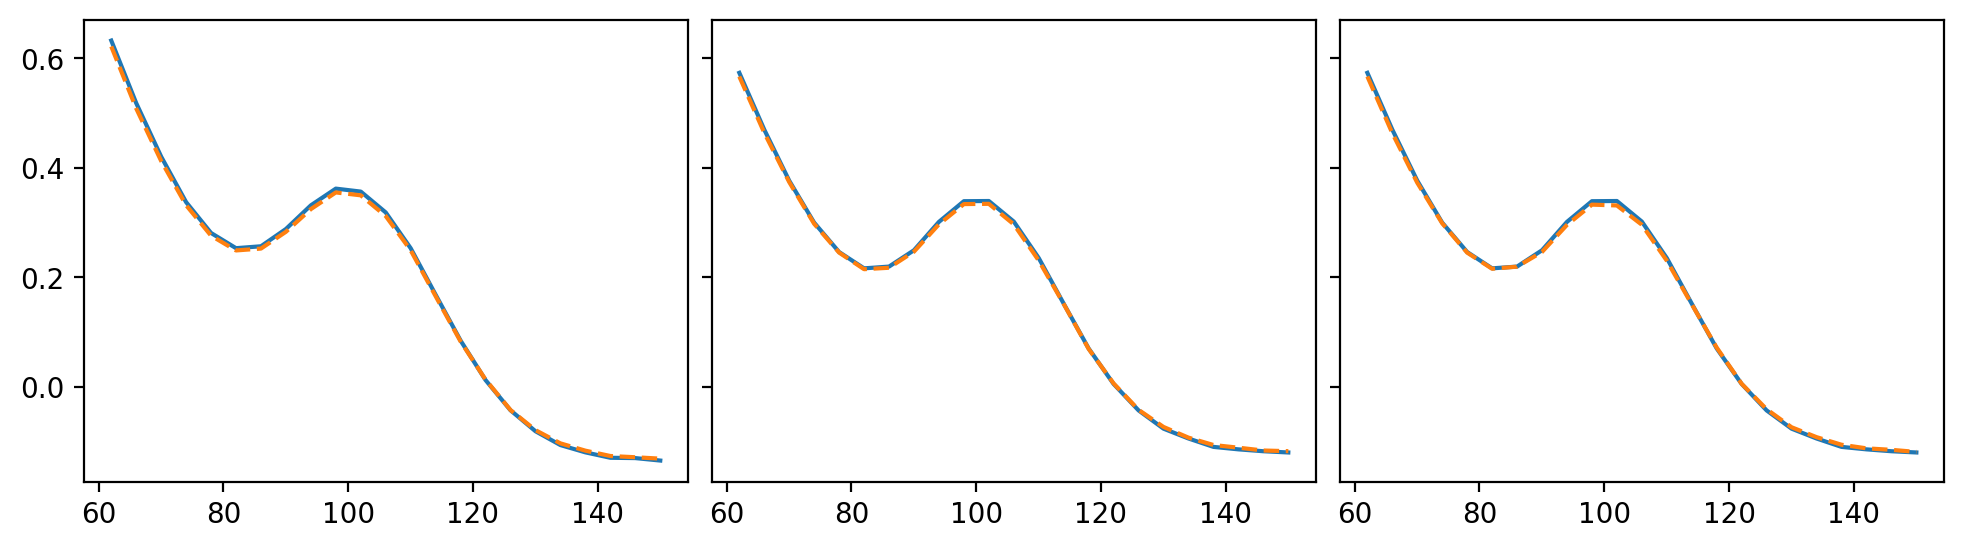

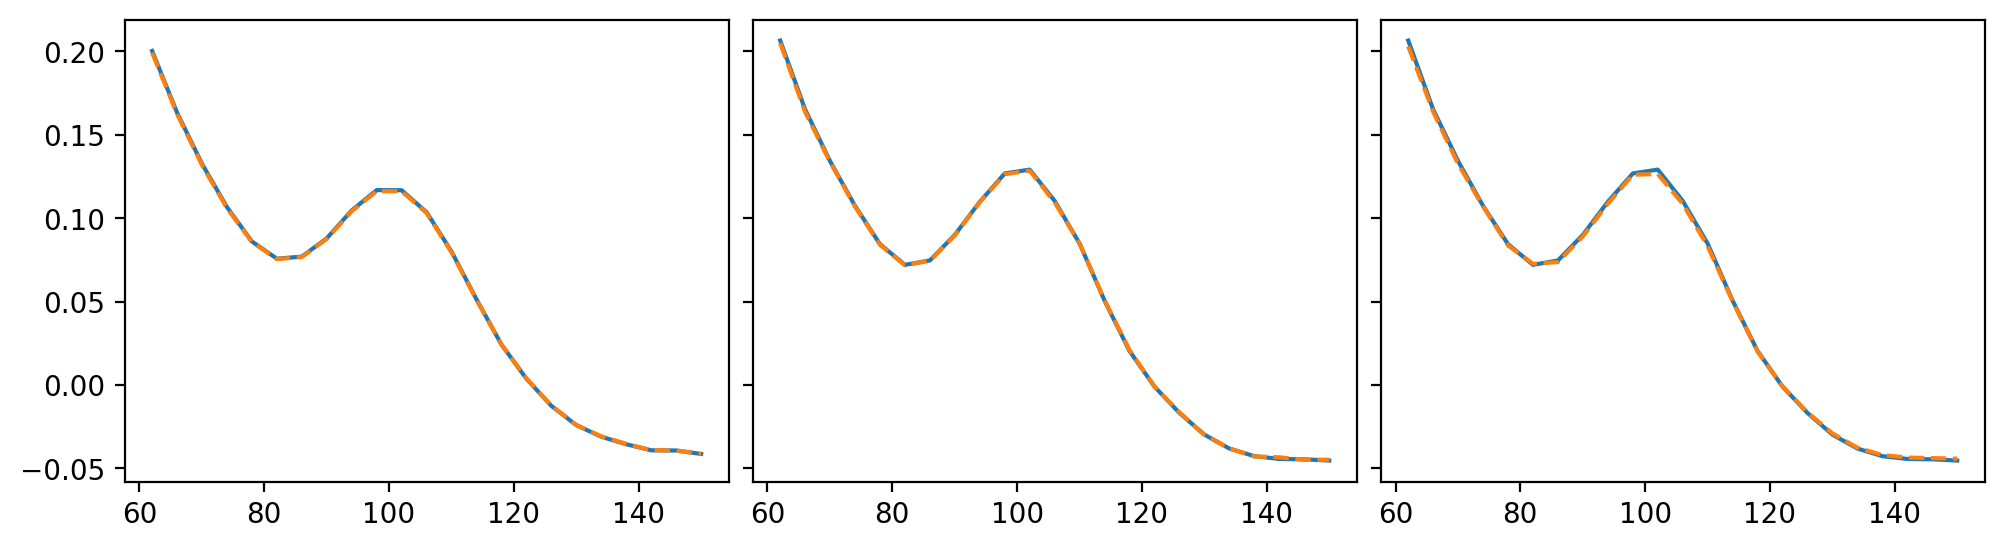

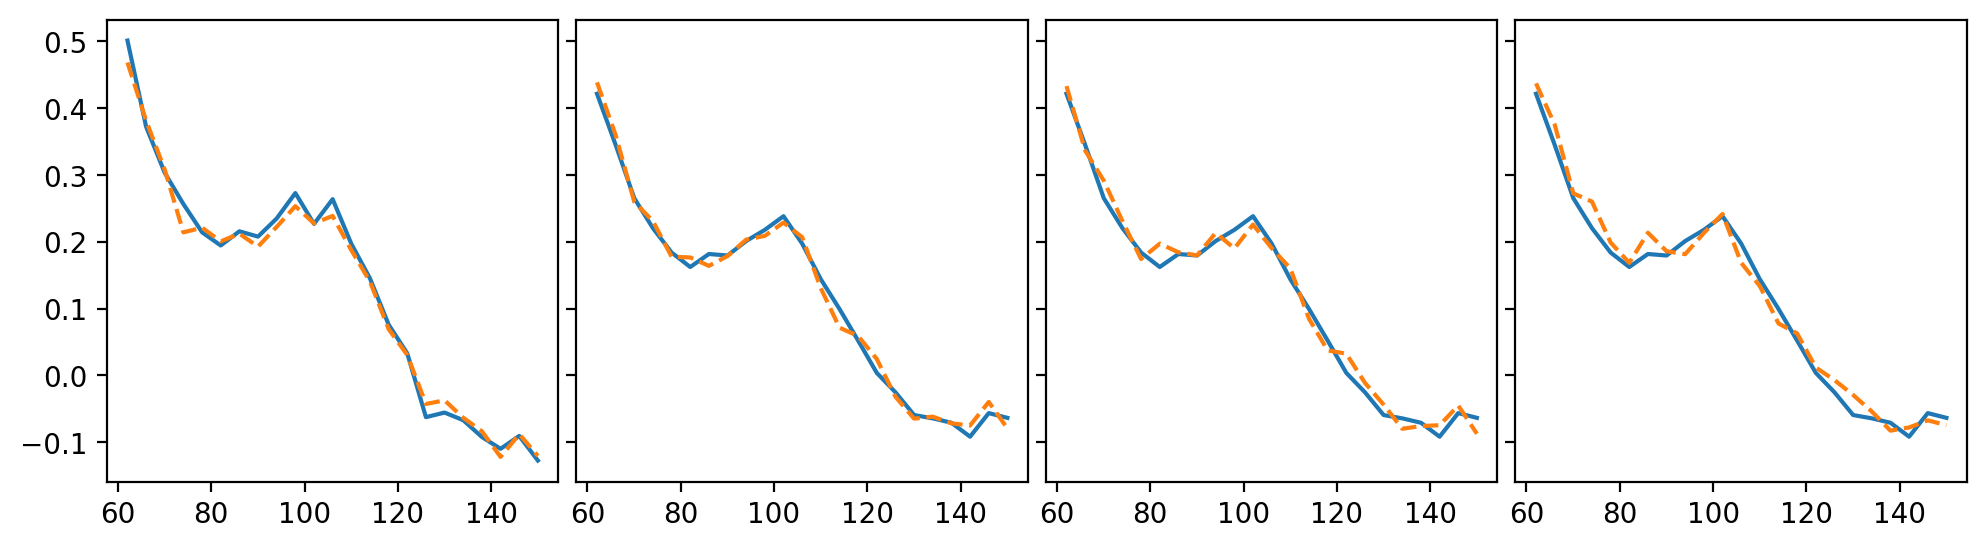

In [23]:
compare = 'xipoles' #xipoles, mpslog, pkpoles
plotting = 'direct'
(rmin, rmax, binning, lens) = bins(compare)
# (kmin, kmax, binning, lenk) = bins(compare)

rmin = 60
rmax = 150
binning = 4

sys_models = ['standard','dv-obs']
tracers = ['LRG','ELG','QSO']
mockids = range(0,25)

for tracer in tracers:
    lenfig = len(REDSHIFT_VSMEAR[tracer])
    fig, ax = plt.subplots(1,lenfig, figsize = (12,3), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 
    for i,(zmin, zmax) in enumerate(REDSHIFT_VSMEAR[tracer]):
        mpspk_dv_obs = []
        mpspk_dv_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}'
                catalog_fn = basedir+f'/mpspk/{{}}_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'.format(compare)
                if compare =='xipoles':
                    result = TwoPointCorrelationFunction.load(catalog_fn)
                    result = result[::binning,::]
                    result.select((rmin, rmax))
                    ks, mpspk = project_to_multipoles(result, ells=[0,2])
                elif compare =='pkpoles':
                    result = PowerSpectrumMultipoles.load(catalog_fn)
                    result = result.select((kmin,kmax,binning))
                    mpspk = np.real(result.get_power())
                    ks = result.kavg
                # ax[i].plot(s, s**2*xi[0])
                if sys_model in ['dv-obs']:
                    mpspk_dv_obs.append(mpspk)
                if sys_model in ['standard']:
                    mpspk_dv_standard.append(mpspk)
                    # ax[i].plot(s, s**2*xi[0],lw = 1)
        # for xi_dv in [xi_dv_obs, xi_dv_standard]:
        mpspk_dv_standard = [np.mean(mpspk_dv_standard, axis=0), np.std(mpspk_dv_standard, axis=0)]
        mpspk_dv_obs = [np.mean(mpspk_dv_obs, axis=0), np.std(mpspk_dv_obs, axis=0)]

        
        if plotting == 'direct':
            ell = 0
            ax[i].plot(ks, ks**1*mpspk_dv_standard[0][ell])
            ax[i].plot(ks, ks**1*mpspk_dv_obs[0][ell],ls = '--')

        if plotting == 'Y3_error':
            ell = 0
            ax[i].plot(ks, (mpspk_dv_obs[0][ell]-mpspk_dv_standard[0][ell])/mpspk_dv_standard[1][ell])
            ax[i].fill_between(ks, -1 , 1, color = '#d1e7f7', alpha=0.2)
            ax[i].axhline(y=1, color = 'black', ls='--')
            ax[i].axhline(y=-1, color = 'black', ls='--')
            ax[i].axhline(y=0, color='black', lw=0.6)
            label = f'{tracer} z{zmin}-{zmax}'
            line= Line2D([0], [0], label=label, color='none', alpha=0)
            leg1 = ax[i].legend(handles=[line], loc=1, fontsize=14)
            leg1.get_frame().set_linewidth(0.0)